In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %matplotlib widget
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import xarray as xr
import numpy as np
import pandas as pd

In [4]:
xr.set_options(keep_attrs=True)

In [5]:
import ecephys_analyses as ea 
from ecephys import utils
from ecephys.signal.xarray_utils import filter_dataset_by_hypnogram

In [6]:
subject = "Doppio"
experiment = "novel_objects_deprivation"
norm_condition = "light-period-circadian-match"
bsl_condition = "recovery-sleep-circadian-match"
rec_condition = "recovery-sleep"
states = ["N1", "N2"]
duration = '02:00:00'
light_period_start = '09:00:00'
light_period_end = '21:00:00'
f_range = (0.5, 4)

In [7]:
norm_hyp = ea.load_hypnogram(subject, experiment, norm_condition)
norm_hyp = norm_hyp.keep_states(states).keep_between(light_period_start, light_period_end)

norm_pow = ea.load_power(subject, experiment, norm_condition, "spg.nc").sel(frequency=slice(*f_range)).sum(dim="frequency")
norm_pow = filter_dataset_by_hypnogram(norm_pow, norm_hyp).swap_dims({'time': 'datetime'}).drop_vars(['time', 'timedelta'])

In [8]:
rec_hyp = ea.load_hypnogram(subject, experiment, rec_condition)
rec_hyp = rec_hyp.keep_states(states).keep_first(duration)

rec_pow = ea.load_power(subject, experiment, rec_condition, "spg.nc").sel(frequency=slice(*f_range)).sum(dim='frequency')
rec_pow = filter_dataset_by_hypnogram(rec_pow, rec_hyp).swap_dims({'time': 'datetime'}).drop_vars(['time', 'timedelta'])
rec_pow = rec_pow / norm_pow.mean(dim="datetime") * 100

In [9]:
bsl_hyp = ea.load_hypnogram(subject, experiment, bsl_condition)
bsl_hyp = bsl_hyp.keep_states(states).keep_between(rec_hyp.start_time.min().strftime("%H:%M:%S"), light_period_end).keep_first(duration)

bsl_pow = ea.load_power(subject, experiment, bsl_condition, "spg.nc").sel(frequency=slice(*f_range)).sum(dim='frequency')
bsl_pow = filter_dataset_by_hypnogram(bsl_pow, bsl_hyp).swap_dims({'time': 'datetime'}).drop_vars(['time', 'timedelta'])
bsl_pow = bsl_pow / norm_pow.mean(dim="datetime") * 100

In [10]:
def match_lengths(dataframes):
    length = min(list(map(len, dataframes)))
    return (df.iloc[:length] for df in dataframes)

In [11]:
bsl_df = bsl_pow.to_dataframe().reset_index(drop=True).rename_axis(index='pair', columns='region').stack().to_frame(name='baseline')
rec_df = rec_pow.to_dataframe().reset_index(drop=True).rename_axis(index='pair', columns='region').stack().to_frame(name='recovery')
bsl_df, rec_df = match_lengths((bsl_df, rec_df))
df = bsl_df.join(rec_df).rename_axis(columns='condition')

In [12]:
df_plot = df.stack().to_frame(name='power')
df_plot['log_power'] = np.log(df_plot.power)
df_plot['sqrt_power'] = np.sqrt(df_plot.power)

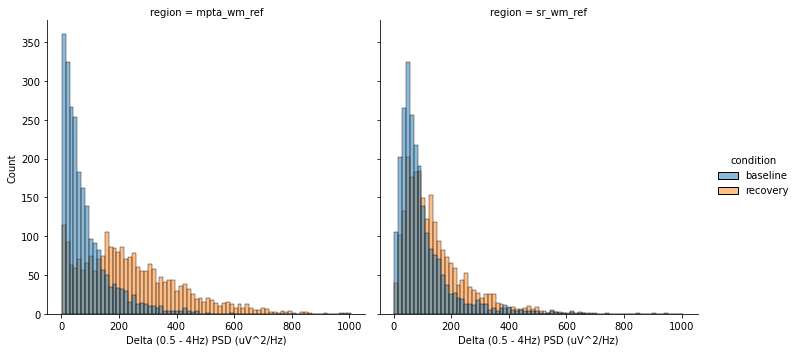

In [13]:
g = sns.displot(data=df_plot, x='power', hue='condition', col='region', kind='hist')
g.set(xlabel='Delta (0.5 - 4Hz) PSD (uV^2/Hz)')
g.tight_layout()

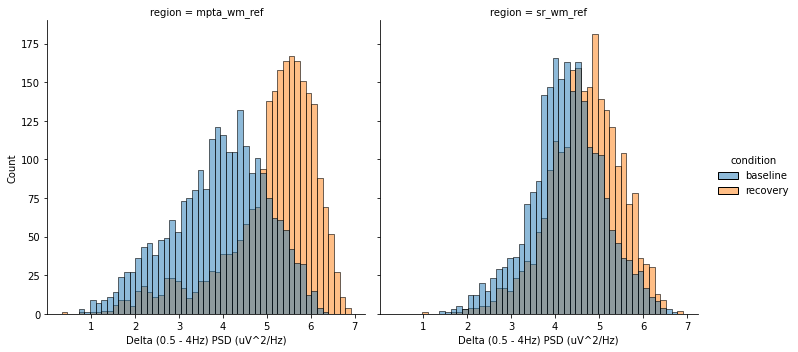

In [14]:
g = sns.displot(data=df_plot, x='log_power', hue='condition', col='region', kind='hist')
g.set(xlabel='Delta (0.5 - 4Hz) PSD (uV^2/Hz)')
g.tight_layout()

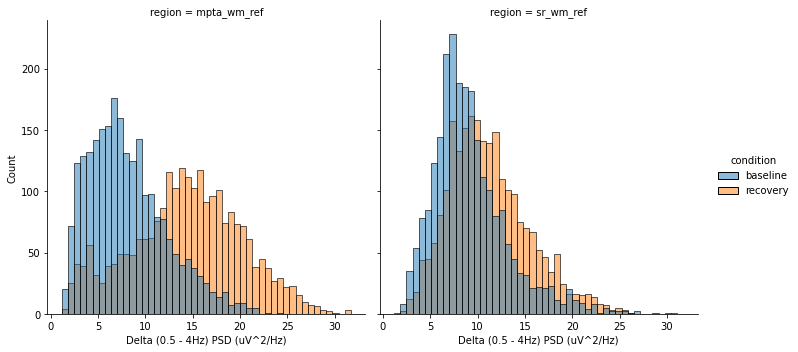

In [15]:
g = sns.displot(data=df_plot, x='sqrt_power', hue='condition', col='region', kind='hist')
g.set(xlabel='Delta (0.5 - 4Hz) PSD (uV^2/Hz)')
g.tight_layout()

In [16]:
def get_relative_rebound(df):
    means = df.groupby('region').mean()
    rebounds = means.recovery - means.baseline
    return rebounds.mpta_wm_ref - rebounds.sr_wm_ref

In [17]:
def shuffle(df, key): 
    _df = df.reset_index()
    labels = _df[key].values.reshape(-1, 2)
    rng = np.random.default_rng()
    rng.permuted(labels, axis=1, out=labels)
    _df.set_index(df.index.names, inplace=True)
    return _df

In [18]:
observed = get_relative_rebound(df)

n_permutations = 10000
permutations = list()
for i in range(n_permutations):
    permuted = shuffle(df, 'region')
    permutations.append(get_relative_rebound(permuted))

In [19]:
perms = pd.Series(permutations).rename_axis(index='permutation').to_frame(name='relative_rebound')

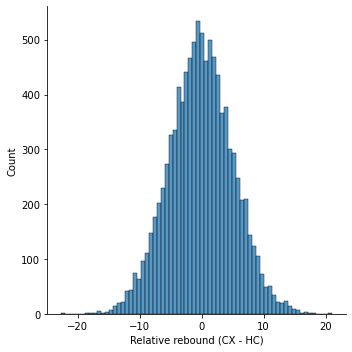

In [20]:
g = sns.displot(data=perms, x='relative_rebound', kind='hist')
g.set(xlabel='Relative rebound (CX - HC)')
g.tight_layout()

In [21]:
p = np.sum(perms >= observed)

In [22]:
print(f"Subject: {subject}")
print('Observed relative rebound (CX - HC):')
print(f'\t{observed}')
print('Shuffled >= observed:')
print(f"\t{1 + p.squeeze()} / {n_permutations}")

Subject: Doppio
Observed relative rebound (CX - HC):
	114.2916326621085
Shuffled >= observed:
	1 / 10000
